<a href="https://colab.research.google.com/github/jazu1412/LOW_CODE_AUTOML_AUTOGLUON/blob/master/IMAGE%20CLASSIFIER/beginner_semantic_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoMM for Semantic Segmentation - Quick Start



Semantic Segmentation is a computer vision task where the objective is to create a detailed pixel-wise segmentation map of an image, assigning each pixel to a specific class or object. This technology is crucial in various applications, such as in autonomous vehicles to identify vehicles, pedestrians, traffic signs, pavement, and other road features.

The Segment Anything Model (SAM) is a foundational model pretrained on a vast dataset with 1 billion masks and 11 million images. While SAM performs exceptionally well on generic scenes, it encounters challenges when applied to specialized domains like remote sensing, medical imagery, agriculture, and manufacturing. Fortunately, AutoMM comes to the rescue by facilitating the fine-tuning of SAM on domain-specific data.

In this easy-to-follow tutorial, we will guide you through the process of using AutoMM to fine-tune SAM. With just a single call to the `fit()` API, you can effortlessly train the model.


## Prepare Data
For demonstration purposes, we use the [Leaf Disease Segmentation](https://www.kaggle.com/datasets/sovitrath/leaf-disease-segmentation-with-trainvalid-split) from Kaggle. This dataset is a good example for automating disease detection in plants, especially for speeding up the plant pathology process. Segmenting specific regions on leaves or plants can be quite challenging, particularly when dealing with smaller diseased areas or various types of diseases.

To begin, download and prepare the dataset.

In [1]:
!pip install autogluon.multimodal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtim

In [1]:
!pip uninstall -y torchaudio
!pip install torchaudio

Found existing installation: torchaudio 2.4.0+cu121
Uninstalling torchaudio-2.4.0+cu121:
  Successfully uninstalled torchaudio-2.4.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
ERROR: pip's dependency resolver does n

In [2]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.5 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.4.1 which is incompatible.
autogluon-multimodal 1.1.1 requires torchvision<0.19.0,>=0.16.0, but you have torchvision 0.19.1 which is incompatible.


In [1]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/semantic_segmentation/leaf_disease_segmentation.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 53.3M/53.3M [00:16<00:00, 3.21MiB/s]


Next, load the CSV files, ensuring that relative paths are expanded to facilitate correct data loading during both training and testing.

In [2]:
import pandas as pd
import os
dataset_path = os.path.join(download_dir, 'leaf_disease_segmentation')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = 'image'
label_col = 'label'

In [3]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

for per_col in [image_col, label_col]:
    train_data[per_col] = train_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    val_data[per_col] = val_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    test_data[per_col] = test_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))


print(train_data[image_col].iloc[0])
print(train_data[label_col].iloc[0])

/content/ag_automm_tutorial/leaf_disease_segmentation/train_images/00002.jpg
/content/ag_automm_tutorial/leaf_disease_segmentation/train_masks/00002.png


Each Pandas DataFrame contains two columns: one for image paths and the other for corresponding groundtruth masks. Let's take a closer look at the training data DataFrame.

In [4]:
train_data.head()

,image,label
0,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
1,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
2,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
3,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
4,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('image').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('image')):
  _plot_series(series, series_name, i)
  fig.legend(title='image', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['label'].value_counts()
    for x_label, grp in _df_6.groupby('image')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('image')
_ = plt.ylabel('label')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['image'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='index', y='image', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

We can also visualize one image and its groundtruth mask.

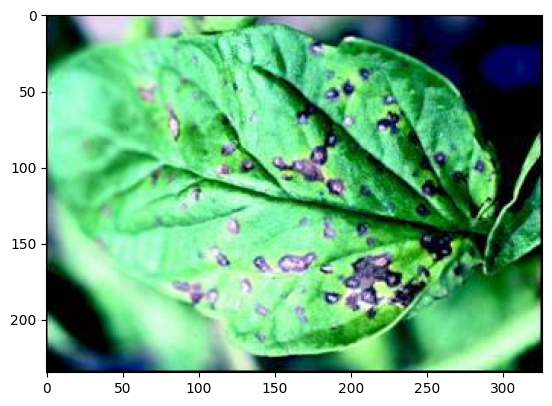

In [5]:
from autogluon.multimodal.utils import SemanticSegmentationVisualizer
visualizer = SemanticSegmentationVisualizer()
visualizer.plot_image(test_data.iloc[0]['image'])

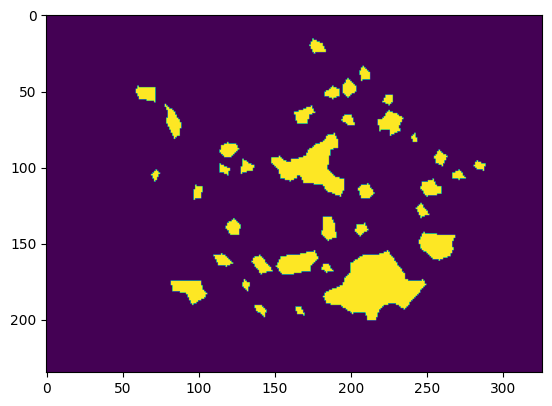

In [6]:
visualizer.plot_image(test_data.iloc[0]['label'])

## Zero Shot Evaluation

Now, let's see how well the pretrained SAM can segment the images. For this demonstration, we'll use the base SAM model.

In [7]:
from autogluon.multimodal import MultiModalPredictor
predictor_zero_shot = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label=label_col,
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    num_classes=1, # forground-background segmentation
)

After initializing the predictor, you can perform inference directly.

In [8]:
pred_zero_shot = predictor_zero_shot.predict({'image': [test_data.iloc[0]['image']]})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

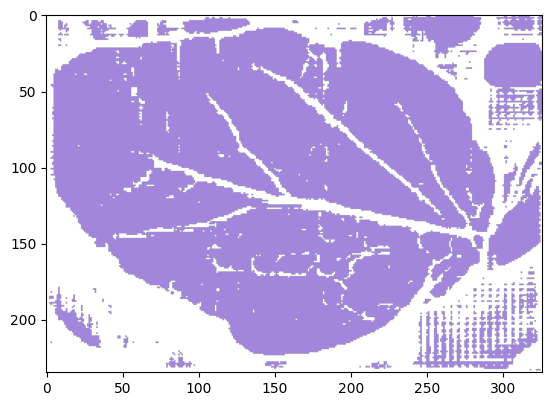

In [9]:
visualizer.plot_mask(pred_zero_shot)

It's worth noting that SAM without prompts outputs a rough leaf mask instead of disease masks due to its lack of context about the domain task. While SAM can perform better with proper click prompts, it might not be an ideal end-to-end solution for some applications that require a standalone model for deployment.

You can also conduct a zero-shot evaluation on the test data.

In [10]:
scores = predictor_zero_shot.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'iou': 0.1398000568151474}


As expected, the test score of the zero-shot SAM is relatively low. Next, let's explore how to fine-tune SAM for enhanced performance.

## Finetune SAM

Initialize a new predictor and fit it with the training and validation data.

In [11]:
from autogluon.multimodal import MultiModalPredictor
import uuid
save_path = f"./tmp/{uuid.uuid4().hex}-automm_semantic_seg"
predictor = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label="label",
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    path=save_path,
)
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,
    time_limit=180, # seconds
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.4.1+cu121
CUDA Version:       12.1
Memory Avail:       8.49 GB / 12.67 GB (67.0%)
Disk Space Avail:   69.52 GB / 112.64 GB (61.7%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/f49ff2d221774de094532d981b62129d-automm_semantic_seg
    ```

INFO: Seed set to 0
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU Count: 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 85: 'val_iou' reached 0.58607 (best 0.58607), saving model to '/content/tmp/f49ff2d221774de094532d981b62129d-automm_semantic_seg/epoch=0-step=85.ckpt' as top 3
/usr/local/lib/python3.10/dist-packages/autogluon/multimodal/utils/checkpoint.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use 

Under the hood, we use [LoRA](https://arxiv.org/abs/2106.09685) for efficient fine-tuning. Note that, without hyperparameter customization, the huge SAM serves as the default model, which requires efficient fine-tuning in many cases.

After fine-tuning, evaluate SAM on the test data.

In [12]:
scores = predictor.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'iou': 0.5625725984573364}


Thanks to the fine-tuning process, the test score has significantly improved.

To visualize the impact, let's examine the predicted mask after fine-tuning.

In [13]:
pred = predictor.predict({'image': [test_data.iloc[0]['image']]})

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

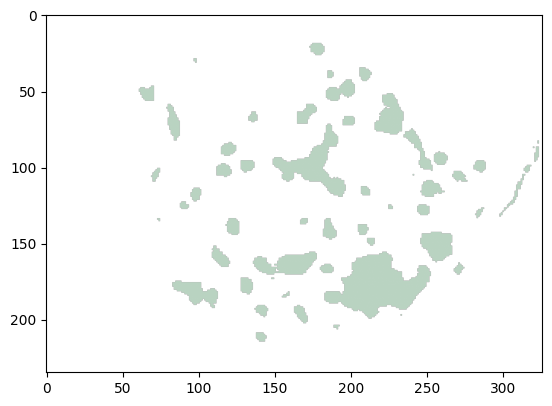

In [14]:
visualizer.plot_mask(pred)

As evident from the results, the predicted mask is now much closer to the groundtruth. This demonstrates the effectiveness of using AutoMM to fine-tune SAM for domain-specific applications, enhancing its performance in tasks like leaf disease segmentation.

## Save and Load

The trained predictor is automatically saved at the end of `fit()`, and you can easily reload it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [15]:
loaded_predictor = MultiModalPredictor.load(save_path)
scores = loaded_predictor.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Load pretrained checkpoint: /content/tmp/f49ff2d221774de094532d981b62129d-automm_semantic_seg/model.ckpt
/usr/local/lib/python3.10/dist-packages/autogluon/multimodal/learners/base.py:2111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.5625725984573364}


We can see the evaluation score is still the same as above, which means same model!

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).